# Tree shape diversity

### The plot elements below will be saved to `/analysis/output/NDS-LB/`

In [89]:
import glob
import pickle
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LogNorm, Normalize, to_hex
from svgutils.compose import *
import altair as alt

import utils.phenotype_colorscales as pc
# from utils.metadata import df_renamed as metadata

In [90]:
results = "../nextflow/results/"
# ranking_coeff_subdir = 'default'
ranking_coeff_subdir = 'naive_reversions_no_bp'
# ranking_coeff_subdir = 'naive_reversions_first'
scale = 20 # must be 5 or 20
outbase = "output/NDS-LB/"

In [91]:
# output_dir = f"output/NDS-LB/test"
output_dir = f"{outbase}/{ranking_coeff_subdir}"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

## Load GC trees and constuct a data frame of statistics

In [92]:
# results = "../nextflow/results"
metadata = (
    pd.read_csv(f"../metadata.csv", index_col=0)
    .rename(
        columns={
            "imm_duration": "time",
            "gc": "GC"
        }
    )
)
metadata.query("(strain == 'wt') & (cell_type == 'GC') & (time != 'w10')", inplace=True)
metadata

,PR,time,mouse,GC,strain,node,cell_type,plate,hc_barcode,lc_barcode,row,col,old_uid,old_mouse,old_gc
uid,,,,,,,,,,,,,,,
D15_M1_GC1,2.01,d15,1,1,wt,RP,GC,2,9,9,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12,PR2.01_mouse1_GC1A,1,1A
D15_M1_GC2,2.01,d15,1,2,wt,RI,GC,3,2,1,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12,PR2.01_mouse1_GC1C,1,1C
D15_M1_GC3,2.01,d15,1,3,wt,LI,GC,4,14,2,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12,PR2.01_mouse1_GC1D,1,1D
D15_M2_GC4,2.01,d15,2,4,wt,RP,GC,5,10,11,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12,PR2.01_mouse2_GC2A,2,2A
D15_M3_GC5,2.01,d15,3,5,wt,RP,GC,6,7,4,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12,PR2.01_mouse3_GC3A,3,3A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D20_M24_GC117,1.04,d20,24,117,wt,RP,GC,72,16,16,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12,PR1.04_mouse5_GC81,5,81
D20_M25_GC118,1.02,d20,25,118,wt,RP,GC,65,8,8,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12,PR1.02_mouse6_GC74,6,74
D20_M25_GC119,1.03,d20,25,119,wt,RP,GC,68,9,9,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12,PR1.03_mouse6_GC77,6,77


In [93]:
len(metadata.index.unique())

121

In [94]:
metadata.time.value_counts()

time
d20    67
d15    54
Name: count, dtype: int64

In [95]:
def gc_key(file):
    PR_str = file.split("/")[-3].split("-")
    # PR_str = file.split("/")[-2].split("-")
    
    return PR_str[0][2:], PR_str[1], PR_str[3]
    # return PR_str[1], PR_str[3]

files = sorted(glob.glob(f"{results}/gctrees/PR*/{ranking_coeff_subdir}/gctree.p"), key=gc_key)
print(len(files))


138


In [96]:

# files = sorted(glob.glob(f"{results}/gctrees/PR*/gctree.p"), key=gc_key)

trees = {}
skipped = 0
for file in files:
    # key = "_".join(f"{x}{y}" for x, y in zip(("mouse", "GC"), gc_key(file)))
    PR, mouse, gc = gc_key(file)
    day = "15" if PR[0] == "2" else "20"
    key = f"D{day}_M{mouse}_GC{gc}"
    if key in metadata.index:
        if key in trees:
            raise ValueError(key, "already loaded!")
        trees[key] = pickle.load(open(file, "rb"))
    else:
        skipped += 1

all_trees = set(metadata.index)
loaded_trees = set(trees.keys())
missing_trees = all_trees - loaded_trees
if missing_trees:
    print("missing trees for", missing_trees)
    
print(f"loaded {len(trees)} GC trees")
print(f"skipped {skipped} GC trees")

missing trees for {'D15_M12_GC28', 'D15_M13_GC33'}
loaded 119 GC trees
skipped 19 GC trees


In [97]:
stat = "REI"
# taus = np.logspace(-2, 0, 10)
taus = np.linspace(0.05, 1, 20)
# taus = [0.05, 0.1, 1]

# stat = "LBI"
# taus = np.logspace(-1, 1, 50)

In [98]:
def calc_tree_stat(tree, stat, tau):
    if stat == "REI":
        total_abundance = sum(node.abundance for node in tree.tree.traverse())
        for node in tree.tree.traverse():
            REI = sum(
                node2.abundance * tau ** node2.get_distance(node) 
                for node2 in node.traverse()
            ) / total_abundance
            node.REI = np.clip(REI, a_min=0.0, a_max=None)
    elif stat.startswith("LB"):
        tree.local_branching(tau=tau)
    else:
        raise ValueError(f"unknown stat {stat}")

In [99]:
df = pd.DataFrame()

row = 0
for tau in taus:
    for key, tree in trees.items():
        pr, mouse, gc = key.split("_")
        mouse = mouse.lstrip("mouse")

        calc_tree_stat(tree, stat, tau)
        
        gc = gc.lstrip("GC")
        df.loc[row, "uid"] = key
        df.loc[row, "τ"] = tau
        df.loc[row, "PR"] = metadata.PR[key]
        df.loc[row, "mouse"] = str(metadata.mouse[key])
        df.loc[row, "GC"] = str(metadata.GC[key])
        df.loc[row, "time"] = metadata.time[key]
        
        abundances = np.array([node.abundance for node in tree.tree.traverse()])

        if len(tree.tree.children) == 1:
            print(f"NOTE: tree {key} has only one root clade")
        root = tree.tree

        clade_sizes = [sum(node.abundance for node in child.traverse()) for child in root.children]
        df.loc[row, "cells sampled"] = sum(abundances)
        df.loc[row, "normalized dominance score"] = max(clade_sizes) / sum(clade_sizes)
        df.loc[row, f"maximum {stat}"] = np.nanmax([getattr(node, stat) for node in tree.tree.traverse()])    
        
        # note: additive delta_bind for now
        delta_bind_dat = []
        for node in tree.tree.traverse():
            if not np.isnan(node.delta_bind):
                for _ in range(node.abundance):
                    delta_bind_dat.append(node.delta_bind)
        df.loc[row, "max Δaffinity"] = np.nanmax(delta_bind_dat)
        df.loc[row, "95th percentile Δaffinity"] = np.percentile(delta_bind_dat, 95)
        df.loc[row, "mean Δaffinity"] = np.nanmean(delta_bind_dat)
        df.loc[row, "median Δaffinity"] = np.nanmedian(delta_bind_dat)

        max_stat_idx = np.nanargmax([getattr(node, stat) for node in tree.tree.traverse()])
        df.loc[row, f"id of max {stat} node"] = [node.name for node in tree.tree.traverse()][max_stat_idx]
        df.loc[row, f"mutations in max {stat} node"] = [node.aa_substitutions for node in tree.tree.traverse()][max_stat_idx]
        df.loc[row, f"Δaffinity of max {stat} node"] = [node.delta_bind for node in tree.tree.traverse()][max_stat_idx]
        df.loc[row, f"ΔΔaffinity of max {stat} node"] = [node.delta_bind - (node.up.delta_bind if node.up is not None else 0) for node in tree.tree.traverse()][max_stat_idx]
        df.loc[row, f"max {stat} node is root"] = max_stat_idx == 0

        row += 1

df

NOTE: tree D20_M21_GC73 has only one root clade
NOTE: tree D20_M22_GC92 has only one root clade
NOTE: tree D20_M23_GC108 has only one root clade
NOTE: tree D20_M20_GC63 has only one root clade
NOTE: tree D20_M20_GC64 has only one root clade
NOTE: tree D20_M20_GC66 has only one root clade
NOTE: tree D20_M22_GC99 has only one root clade
NOTE: tree D20_M21_GC73 has only one root clade
NOTE: tree D20_M22_GC92 has only one root clade
NOTE: tree D20_M23_GC108 has only one root clade
NOTE: tree D20_M20_GC63 has only one root clade
NOTE: tree D20_M20_GC64 has only one root clade
NOTE: tree D20_M20_GC66 has only one root clade
NOTE: tree D20_M22_GC99 has only one root clade
NOTE: tree D20_M21_GC73 has only one root clade
NOTE: tree D20_M22_GC92 has only one root clade
NOTE: tree D20_M23_GC108 has only one root clade
NOTE: tree D20_M20_GC63 has only one root clade
NOTE: tree D20_M20_GC64 has only one root clade
NOTE: tree D20_M20_GC66 has only one root clade
NOTE: tree D20_M22_GC99 has only one 

,uid,τ,PR,mouse,GC,time,cells sampled,normalized dominance score,maximum REI,max Δaffinity,95th percentile Δaffinity,mean Δaffinity,median Δaffinity,id of max REI node,mutations in max REI node,Δaffinity of max REI node,ΔΔaffinity of max REI node,max REI node is root
0,D20_M20_GC55,0.05,1.01,20,55,d20,94.0,0.595745,0.022423,1.557789,1.409841,0.613606,0.604761,seq51,S64(H)N Y42(L)S S109(L)R L116(L)I,1.409841,0.845052,False
1,D20_M21_GC72,0.05,1.01,21,72,d20,89.0,0.842697,0.047250,2.137760,2.096171,1.066209,1.152517,seq35,A105(H)G E97(L)D Q105(L)H,0.877802,0.380316,False
2,D20_M21_GC73,0.05,1.02,21,73,d20,88.0,1.000000,0.101015,1.939401,1.441473,0.788391,0.987989,seq11,R67(L)K Q105(L)H L116(L)I,0.987989,0.453592,False
3,D20_M22_GC87,0.05,1.02,22,87,d20,75.0,0.613333,0.041335,2.529466,1.651336,0.566714,0.528867,seq4,Y42(L)N N108(L)S,0.957552,0.000000,False
4,D20_M22_GC88,0.05,1.02,22,88,d20,76.0,0.684211,0.028293,2.223187,1.986549,0.530252,0.806858,seq29,I76(H)F L99(L)W L116(L)P,-0.028387,-0.000294,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2375,D15_M17_GC46,1.00,2.04,17,46,d15,75.0,0.373333,1.000000,2.058664,1.702529,0.753565,0.852977,naive,,0.000000,0.000000,True
2376,D15_M17_GC47,1.00,2.04,17,47,d15,79.0,0.620253,1.000000,2.058347,1.961121,1.011471,1.160850,naive,,0.000000,0.000000,True
2377,D15_M18_GC50,1.00,2.04,18,50,d15,82.0,0.365854,1.000000,2.337848,1.973319,0.942385,0.939961,naive,,0.000000,0.000000,True
2378,D15_M19_GC53,1.00,2.04,19,53,d15,73.0,0.520548,1.000000,2.751308,1.810629,0.827990,0.920932,naive,,0.000000,0.000000,True


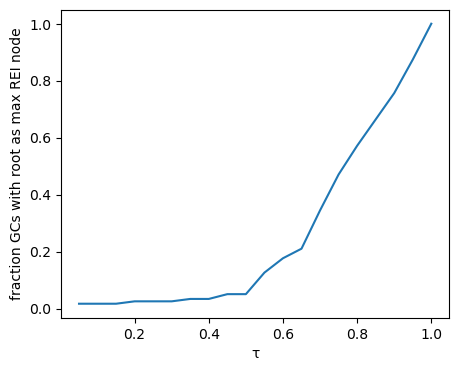

In [100]:
df.groupby("τ")[f"max {stat} node is root"].agg(lambda group: group.astype(int).sum() / len(group)).plot(xlabel="τ", ylabel=f"fraction GCs with root as max {stat} node", figsize=(5, 4));
# plt.xscale("log")

In [101]:
taus

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

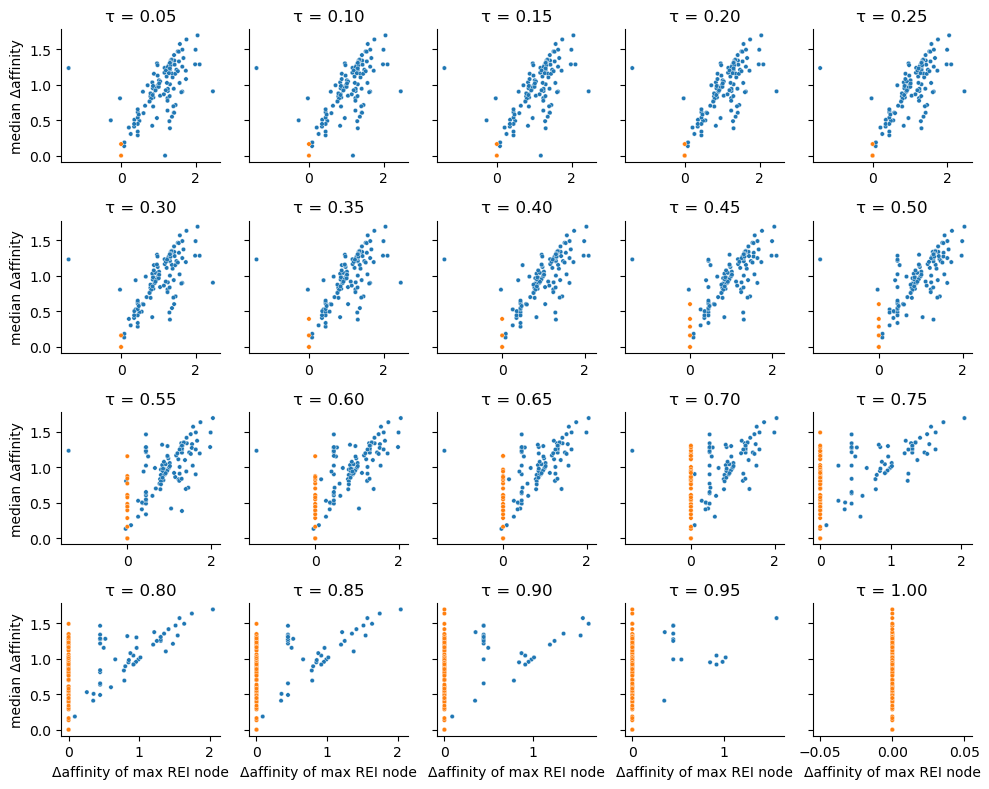

In [102]:
g = sns.relplot(data=df.loc[df.τ.isin(taus)], x=f"Δaffinity of max {stat} node", y="median Δaffinity", col="τ",
                col_wrap=5, hue="max REI node is root", height=2, s=10, legend=False,
                facet_kws={"sharex": False, "sharey": True})
for tau, ax in zip(taus, g.axes):
    ax.set_title(f"τ = {tau:.2f}")
plt.tight_layout()
plt.show()


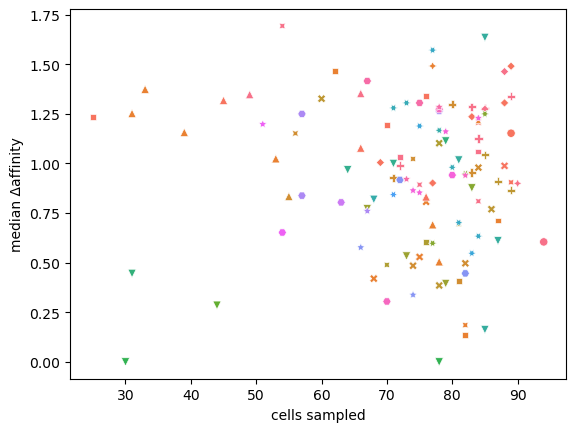

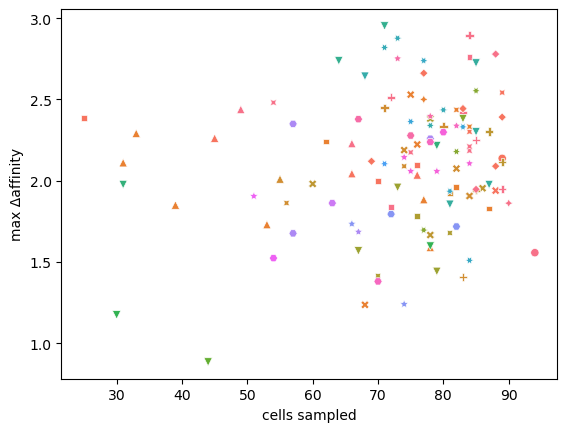

In [103]:
sns.scatterplot(data=df.loc[df.τ == taus[0]], x="cells sampled", y=f"median Δaffinity", hue="mouse", style="PR", legend=False)
plt.show()

sns.scatterplot(data=df.loc[df.τ == taus[0]], x="cells sampled", y=f"max Δaffinity", hue="mouse", style="PR", legend=False)
plt.show()

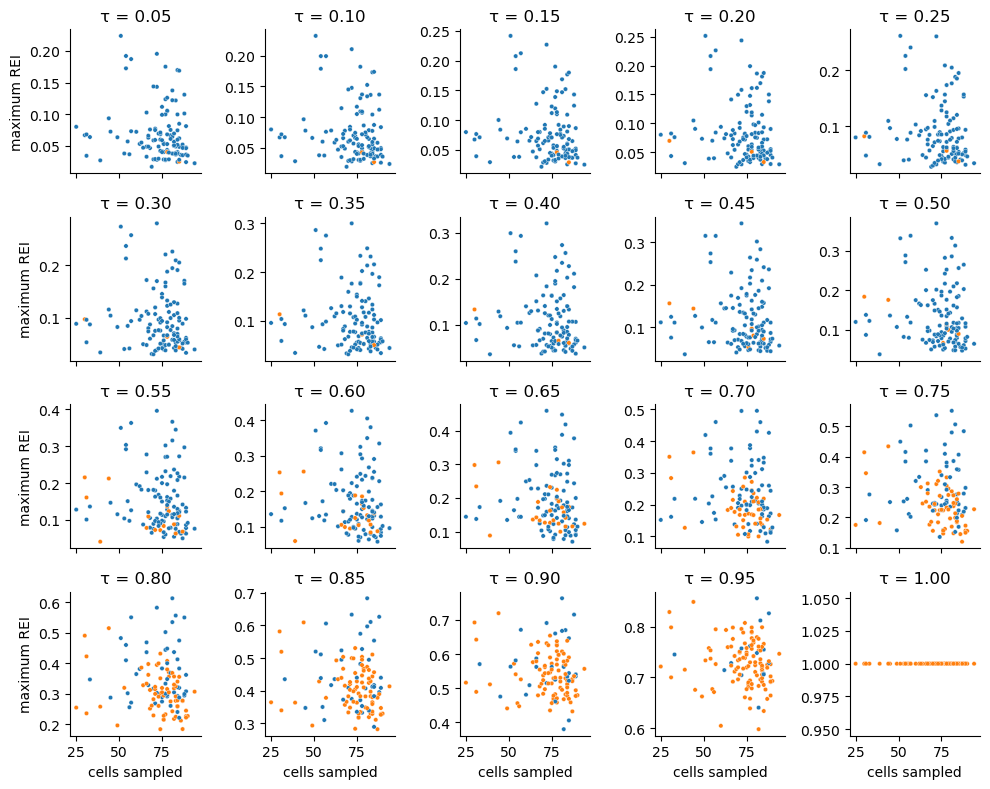

In [104]:
g = sns.relplot(data=df.loc[df.τ.isin(taus)], x="cells sampled", y=f"maximum REI", col="τ",
                col_wrap=5, hue="max REI node is root", height=2, s=10, legend=False,
                facet_kws={"sharex": True, "sharey": False})
for tau, ax in zip(taus, g.axes):
    ax.set_title(f"τ = {tau:.2f}")
plt.tight_layout()
plt.show()

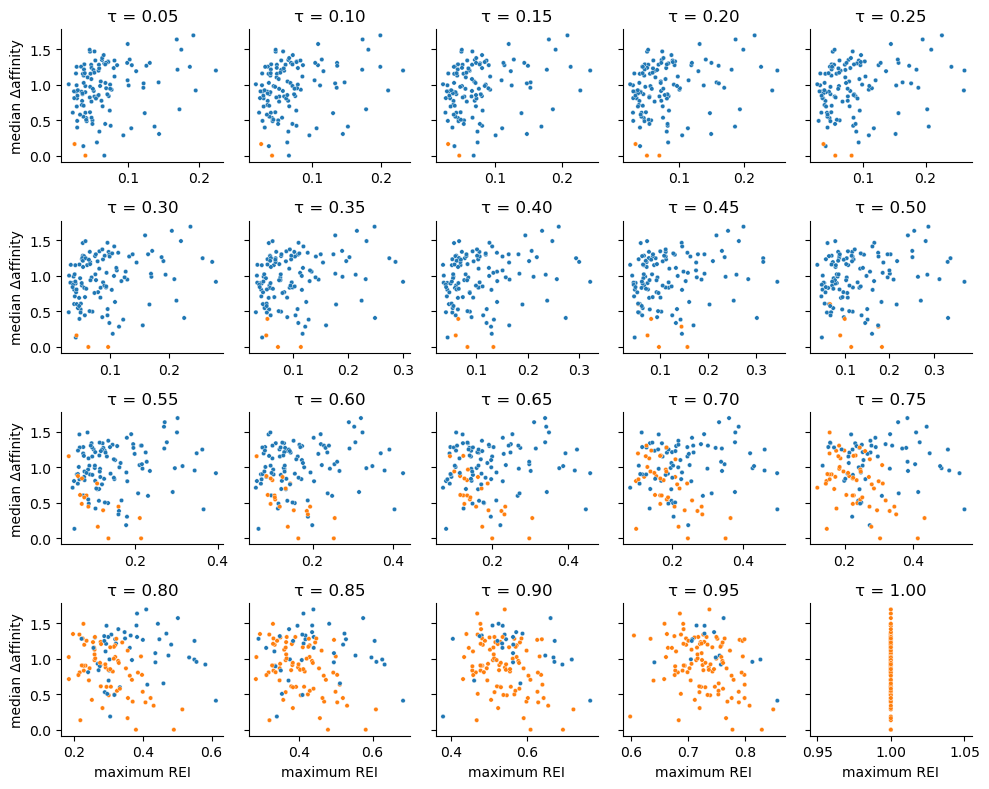

In [105]:
g = sns.relplot(data=df.loc[df.τ.isin(taus)], x=f"maximum REI", y="median Δaffinity", col="τ",
                col_wrap=5, hue="max REI node is root", height=2, s=10, legend=False,
                facet_kws={"sharex": False, "sharey": True})
for tau, ax in zip(taus, g.axes):
    ax.set_title(f"τ = {tau:.2f}")
plt.tight_layout()
plt.show()

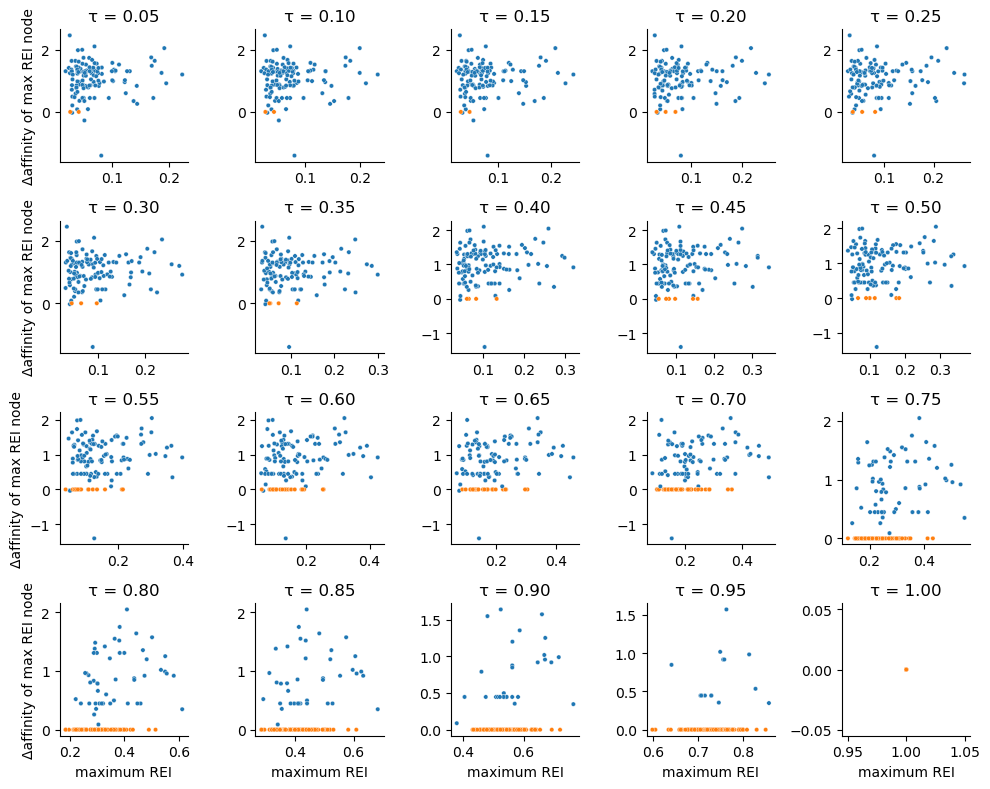

In [106]:
g = sns.relplot(data=df.loc[df.τ.isin(taus)], x=f"maximum REI", y=f"Δaffinity of max {stat} node", col="τ",
                col_wrap=5, hue="max REI node is root", height=2, s=10, legend=False,
                facet_kws={"sharex": False, "sharey": False})
for tau, ax in zip(taus, g.axes):
    ax.set_title(f"τ = {tau:.2f}")
plt.tight_layout()
plt.show()

/var/folders/0w/l84hyz3n6ns582pxy6tkt8y80000gn/T/ipykernel_93633/1009681117.py:3: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  ρ_node, p_node = sp.stats.spearmanr(group_df[f"Δaffinity of max {stat} node"], group_df[f"maximum {stat}"])
/var/folders/0w/l84hyz3n6ns582pxy6tkt8y80000gn/T/ipykernel_93633/1009681117.py:4: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  ρ_gc, p_gc = sp.stats.spearmanr(group_df[f"median Δaffinity"], group_df[f"maximum {stat}"])
/var/folders/0w/l84hyz3n6ns582pxy6tkt8y80000gn/T/ipykernel_93633/1009681117.py:5: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  ρ_aff, p_aff = sp.stats.spearmanr(group_df[f"median Δaffinity"], group_df[f"Δaffinity of max {stat} node"])


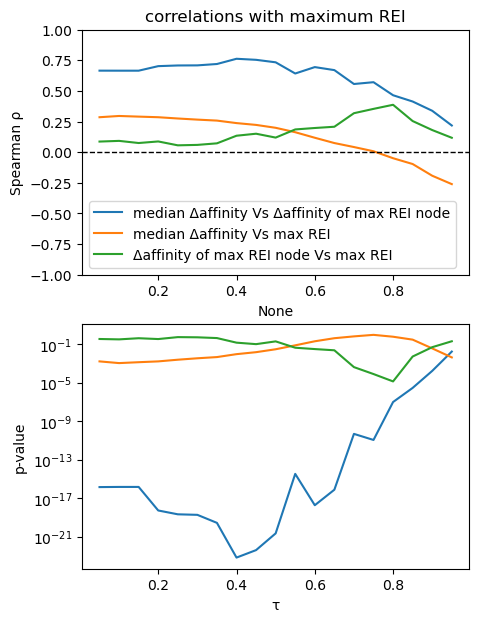

In [107]:
cor_df = pd.DataFrame()
for gc, group_df in df.groupby("τ"):
    ρ_node, p_node = sp.stats.spearmanr(group_df[f"Δaffinity of max {stat} node"], group_df[f"maximum {stat}"])
    ρ_gc, p_gc = sp.stats.spearmanr(group_df[f"median Δaffinity"], group_df[f"maximum {stat}"])
    ρ_aff, p_aff = sp.stats.spearmanr(group_df[f"median Δaffinity"], group_df[f"Δaffinity of max {stat} node"])
    cor_df.loc[gc, "ρ_node"] = ρ_node
    cor_df.loc[gc, "ρ_gc"] = ρ_gc
    cor_df.loc[gc, "p_node"] = p_node
    cor_df.loc[gc, "p_gc"] = p_gc
    cor_df.loc[gc, "ρ_aff"] = ρ_aff
    cor_df.loc[gc, "p_aff"] = p_aff

plt.figure(figsize=(5, 7))
plt.subplot(2, 1, 1)
plt.title(f"correlations with maximum {stat}")
sns.lineplot(data=cor_df, x=cor_df.index, y="ρ_aff", label=f"median Δaffinity Vs Δaffinity of max {stat} node")
sns.lineplot(data=cor_df, x=cor_df.index, y="ρ_gc", label=f"median Δaffinity Vs max {stat}")
sns.lineplot(data=cor_df, x=cor_df.index, y="ρ_node", label=f"Δaffinity of max {stat} node Vs max {stat}")
plt.axhline(0, color="k", ls="--", lw=1)
# plt.xlabel("τ")
plt.ylabel("Spearman ρ")
plt.ylim(-1, 1)
plt.legend()

plt.subplot(2, 1, 2)
sns.lineplot(data=cor_df, x=cor_df.index, y="p_aff")
sns.lineplot(data=cor_df, x=cor_df.index, y="p_gc")
sns.lineplot(data=cor_df, x=cor_df.index, y="p_node")
plt.xlabel("τ")
plt.ylabel("p-value")
plt.yscale("log")
plt.show()

In [108]:
# outcome = "mean Δaffinity"
# outcome = "median Δaffinity"
# outcome = "95th percentile Δaffinity"
outcome = f"Δaffinity of max {stat} node"
# outcome = f"ΔΔaffinity of max {stat} node"

In [109]:
# tau = taus[np.where(tau_cor_df.ρ > 0, tau_cor_df.p, 1).argmin()]
tau = taus[9]
tau

0.49999999999999994

Need to recompute tree stats using the chosen $\tau$

In [110]:
for tree in trees.values():
    calc_tree_stat(tree, stat, tau)

In [111]:
df = df.loc[df["τ"] == tau].sort_values(f"maximum {stat}").reset_index()
df

,index,uid,τ,PR,mouse,GC,time,cells sampled,normalized dominance score,maximum REI,max Δaffinity,95th percentile Δaffinity,mean Δaffinity,median Δaffinity,id of max REI node,mutations in max REI node,Δaffinity of max REI node,ΔΔaffinity of max REI node,max REI node is root
0,1123,D20_M22_GC98,0.5,1.07,22,98,d20,39.0,0.538462,0.038462,1.850529,1.695960,1.001691,1.156421,seq4,Y88(H)F A105(H)G N108(L)K,1.357557,0.052253,False
1,1090,D20_M22_GC91,0.5,1.03,22,91,d20,87.0,0.413793,0.047593,1.829721,1.543686,0.779233,0.712649,seq33,Y103(H)F F10(L)L S12(L)T Y42(L)H N108(L)K L116(L)I,1.457183,0.993188,False
2,1141,D15_M10_GC20,0.5,2.01,10,20,d15,83.0,0.439024,0.048616,2.382069,1.624622,0.665279,0.876932,seq49,A40(L)G Y42(L)H,0.760307,-0.043580,False
3,1089,D20_M22_GC90,0.5,1.03,22,90,d20,82.0,0.390244,0.048780,1.961642,1.546820,0.106269,0.133740,seq15,T96(H)A P72(L)S N93(L)T L99(L)M L116(L)P,0.083487,0.072981,False
4,1075,D20_M22_GC88,0.5,1.02,22,88,d20,76.0,0.684211,0.050164,2.223187,1.986549,0.530252,0.806858,seq29,I76(H)F L99(L)W L116(L)P,-0.028387,-0.000294,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,1101,D20_M23_GC108,0.5,1.04,23,108,d20,83.0,1.000000,0.312688,1.408299,1.077456,0.825044,0.955097,seq12,S64(H)T N92(H)K Y42(L)C N108(L)H,0.955097,-0.028456,False
115,1182,D15_M16_GC42,0.5,2.04,16,42,d15,51.0,0.862745,0.331189,1.905368,1.401910,0.863565,1.197991,seq13,A105(H)G Y66(L)F S109(L)R,1.197991,0.751926,False
116,1092,D20_M23_GC105,0.5,1.03,23,105,d20,81.0,0.962963,0.332031,1.924698,1.241663,0.517769,0.408579,seq12,I78(H)L N92(H)T Y42(L)C,0.348155,0.348155,False
117,1170,D15_M14_GC37,0.5,2.03,14,37,d15,57.0,0.947368,0.337484,2.349854,2.069778,1.100257,1.249952,seq7,A105(H)G A40(L)G,1.249952,0.803887,False


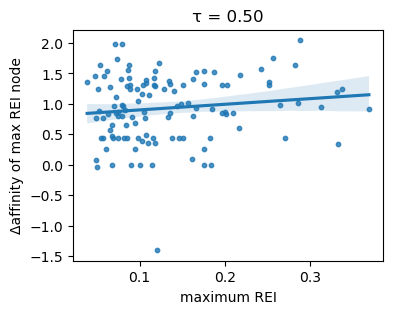

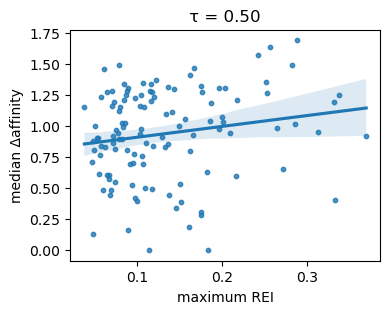

In [112]:
plt.figure(figsize=(4, 3))
sns.regplot(data=df, x=f"maximum {stat}", y=outcome, scatter_kws=dict(s=10))
plt.title(f"τ = {tau:.2f}")
plt.show()

# plt.figure(figsize=(4, 3))
# sns.regplot(data=df.loc[df[outcome] != 0], x=f"maximum {stat}", y=outcome, scatter_kws=dict(s=10), label="no roots")
# plt.title(f"τ = {tau:.2f}")
# plt.legend()
# plt.show()

plt.figure(figsize=(4, 3))
sns.regplot(data=df, x=f"maximum {stat}", y="median Δaffinity", scatter_kws=dict(s=10))
plt.title(f"τ = {tau:.2f}")
plt.show()

In [113]:
thresh = 0.25

In [114]:
df.to_csv(f"{output_dir}/data.csv")

## Rank plot of total GC cell abundance 

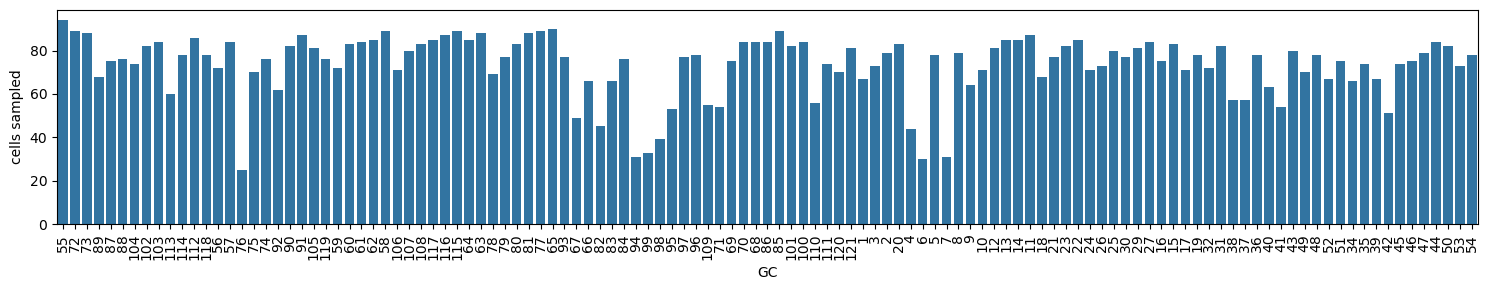

In [115]:
plt.figure(figsize=(15, 3))
ax = sns.barplot(data=df.sort_values(["PR", "mouse", "cells sampled"]), x="GC", y="cells sampled", #hue="mouse",
                #  hue_order=df.mouse.unique(),
                 legend=False,
                 dodge=False)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(f"{output_dir}/abundances.svg")
plt.show()

## Plot tree shape stats in a scatter plot, and render some example trees
For each tree we render it colored by fitness statistic, then by affinity, and by fitness stat

In [116]:
df

,index,uid,τ,PR,mouse,GC,time,cells sampled,normalized dominance score,maximum REI,max Δaffinity,95th percentile Δaffinity,mean Δaffinity,median Δaffinity,id of max REI node,mutations in max REI node,Δaffinity of max REI node,ΔΔaffinity of max REI node,max REI node is root
0,1123,D20_M22_GC98,0.5,1.07,22,98,d20,39.0,0.538462,0.038462,1.850529,1.695960,1.001691,1.156421,seq4,Y88(H)F A105(H)G N108(L)K,1.357557,0.052253,False
1,1090,D20_M22_GC91,0.5,1.03,22,91,d20,87.0,0.413793,0.047593,1.829721,1.543686,0.779233,0.712649,seq33,Y103(H)F F10(L)L S12(L)T Y42(L)H N108(L)K L116(L)I,1.457183,0.993188,False
2,1141,D15_M10_GC20,0.5,2.01,10,20,d15,83.0,0.439024,0.048616,2.382069,1.624622,0.665279,0.876932,seq49,A40(L)G Y42(L)H,0.760307,-0.043580,False
3,1089,D20_M22_GC90,0.5,1.03,22,90,d20,82.0,0.390244,0.048780,1.961642,1.546820,0.106269,0.133740,seq15,T96(H)A P72(L)S N93(L)T L99(L)M L116(L)P,0.083487,0.072981,False
4,1075,D20_M22_GC88,0.5,1.02,22,88,d20,76.0,0.684211,0.050164,2.223187,1.986549,0.530252,0.806858,seq29,I76(H)F L99(L)W L116(L)P,-0.028387,-0.000294,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,1101,D20_M23_GC108,0.5,1.04,23,108,d20,83.0,1.000000,0.312688,1.408299,1.077456,0.825044,0.955097,seq12,S64(H)T N92(H)K Y42(L)C N108(L)H,0.955097,-0.028456,False
115,1182,D15_M16_GC42,0.5,2.04,16,42,d15,51.0,0.862745,0.331189,1.905368,1.401910,0.863565,1.197991,seq13,A105(H)G Y66(L)F S109(L)R,1.197991,0.751926,False
116,1092,D20_M23_GC105,0.5,1.03,23,105,d20,81.0,0.962963,0.332031,1.924698,1.241663,0.517769,0.408579,seq12,I78(H)L N92(H)T Y42(L)C,0.348155,0.348155,False
117,1170,D15_M14_GC37,0.5,2.03,14,37,d15,57.0,0.947368,0.337484,2.349854,2.069778,1.100257,1.249952,seq7,A105(H)G A40(L)G,1.249952,0.803887,False


In [117]:
pc

<module 'utils.phenotype_colorscales' from '/Users/wsdewitt/github/gcreplay/analysis/utils/phenotype_colorscales.py'>

In [118]:
outcome

'Δaffinity of max REI node'

25.0 94.0
d15


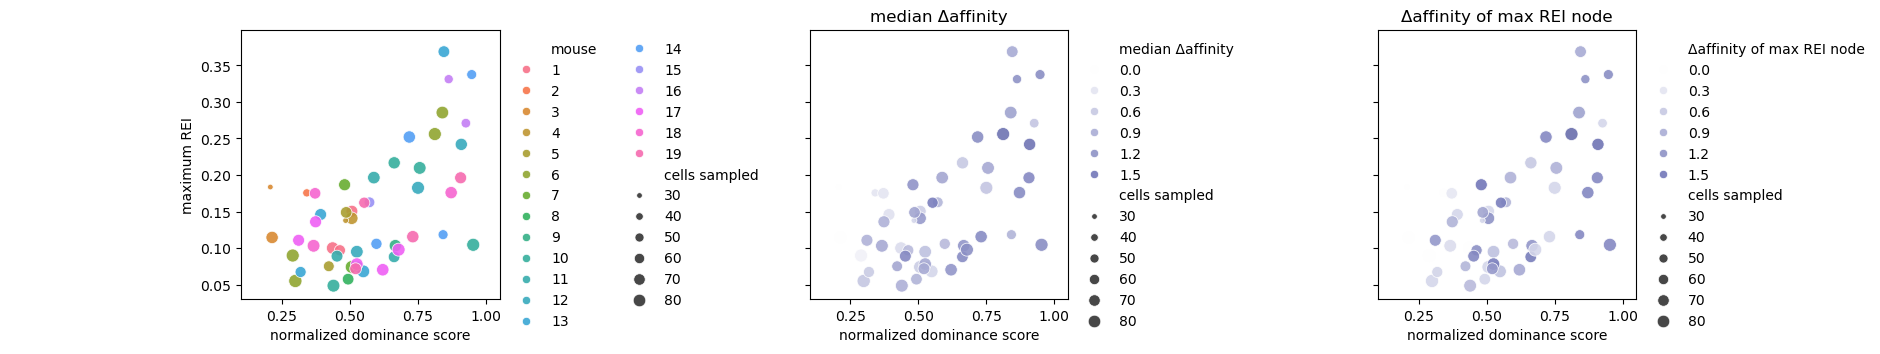

d20


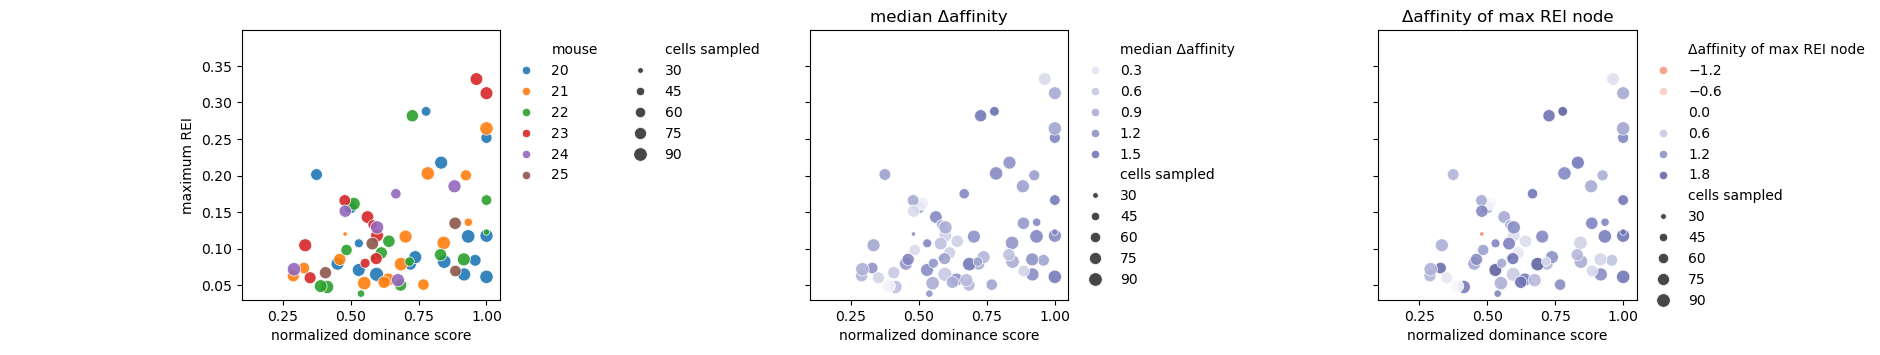

In [119]:
# stat cmap
cmap = "viridis"

vmin = min(getattr(node, stat) for tree in trees.values() for node in tree.tree.traverse())
vmax = max(getattr(node, stat) for tree in trees.values() for node in tree.tree.traverse())
xmargin=0.05
ymargin=0.03
xticks = [0.25, 0.5, 0.75, 1.0]
yticks = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
min_size = df["cells sampled"].min()
max_size = df["cells sampled"].max()
print(min_size, max_size)
# Set up a common normalization for sizes
size_norm = Normalize(vmin=min_size, vmax=max_size)

size_range = (10, 100)

# legend_sizes = [min_size, (min_size + max_size) / 2, max_size]
# legend_markers = [Line2D([0], [0], marker='o', color='w', label=f'{int(size)} cells',
#                          markersize=(20 + (size - min_size) / (max_size - min_size) * 180), 
#                          markerfacecolor='gray', markeredgecolor='gray') 
#                   for size in legend_sizes]

# size_range = (min_cells_sampled, max_cells_sampled)


for time, time_df in df.groupby("time"):
    print(time, flush=True)

    time_df_mouse_sorted = time_df.copy()
    time_df_mouse_sorted["mouse"] = time_df_mouse_sorted["mouse"].astype(int)
    time_df_mouse_sorted.sort_values("mouse", inplace=True)
    time_df_mouse_sorted["mouse"] = time_df_mouse_sorted["mouse"].astype(str)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,3.5), sharey=True, sharex=True)
    # fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, sharex=True)
    sns.scatterplot(data=time_df_mouse_sorted, 
                    x="normalized dominance score", 
                    y=f"maximum {stat}", 
                    hue="mouse", 
                    size="cells sampled", 
                    sizes=size_range,
                    # size_norm=size_norm,
                    # style="time",
                    clip_on=False, 
                    alpha=0.9,
                    legend="brief",
                    size_norm=size_norm,    
                    ax=ax1)

    # ax1.legend(handles=legend_markers, title="mouse", loc='upper right', bbox_to_anchor=(1, 1))
    # # Get the existing hue legend and add it
    # handles, labels = ax1.get_legend_handles_labels()
    # ax1.legend(handles=handles + legend_markers, labels=labels + [f'{int(size)} cells' for size in legend_sizes], 
    #        title="Outcome & Cells Sampled", loc='upper right', bbox_to_anchor=(1, 1))

    ax1.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False, ncol=2)
    # ax1.legend(loc='upper left', frameon=True, ncol=3, fontsize=8)
    # ax1.legend(frameon=False)
    # sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 1))

    ax2.set_title("median Δaffinity")
    sns.scatterplot(data=time_df_mouse_sorted, 
                    x="normalized dominance score", 
                    y=f"maximum {stat}", 
                    hue="median Δaffinity", 
                    size="cells sampled", 
                    sizes=size_range,
                    # style="time",
                    clip_on=False, 
                    alpha=0.9,
                    palette=pc.affinity_trees.cmap, hue_norm=pc.affinity_trees.norm,
                    legend="brief",
                    size_norm=size_norm,
                    ax=ax2)
    ax2.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

    ax3.set_title(outcome)
    sns.scatterplot(data=time_df_mouse_sorted, 
                    x="normalized dominance score", 
                    y=f"maximum {stat}", 
                    hue=outcome, 
                    size="cells sampled", 
                    sizes=size_range,
                    # style="time",
                    clip_on=False, 
                    alpha=0.9,
                    palette=pc.affinity_trees.cmap, hue_norm=pc.affinity_trees.norm,
                    legend="brief",
                    size_norm=size_norm,
                    ax=ax3)
    # move legend for ax3 outside of plot to the right and remove the frame
    ax3.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
    # plt.tight_layout()

    ax1.set_xlim(0.15 - xmargin, 1 + xmargin)
    ax1.set_ylim(vmin + ymargin, vmax + ymargin)
    ax1.set_xticks(xticks)
    ax1.set_yticks(yticks)
    # adjust width between subplots
    plt.subplots_adjust(wspace=1.2)

    plt.savefig(f"{output_dir}/scatter_{time}.svg")
    plt.show()


In [120]:
df

,index,uid,τ,PR,mouse,GC,time,cells sampled,normalized dominance score,maximum REI,max Δaffinity,95th percentile Δaffinity,mean Δaffinity,median Δaffinity,id of max REI node,mutations in max REI node,Δaffinity of max REI node,ΔΔaffinity of max REI node,max REI node is root
0,1123,D20_M22_GC98,0.5,1.07,22,98,d20,39.0,0.538462,0.038462,1.850529,1.695960,1.001691,1.156421,seq4,Y88(H)F A105(H)G N108(L)K,1.357557,0.052253,False
1,1090,D20_M22_GC91,0.5,1.03,22,91,d20,87.0,0.413793,0.047593,1.829721,1.543686,0.779233,0.712649,seq33,Y103(H)F F10(L)L S12(L)T Y42(L)H N108(L)K L116(L)I,1.457183,0.993188,False
2,1141,D15_M10_GC20,0.5,2.01,10,20,d15,83.0,0.439024,0.048616,2.382069,1.624622,0.665279,0.876932,seq49,A40(L)G Y42(L)H,0.760307,-0.043580,False
3,1089,D20_M22_GC90,0.5,1.03,22,90,d20,82.0,0.390244,0.048780,1.961642,1.546820,0.106269,0.133740,seq15,T96(H)A P72(L)S N93(L)T L99(L)M L116(L)P,0.083487,0.072981,False
4,1075,D20_M22_GC88,0.5,1.02,22,88,d20,76.0,0.684211,0.050164,2.223187,1.986549,0.530252,0.806858,seq29,I76(H)F L99(L)W L116(L)P,-0.028387,-0.000294,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,1101,D20_M23_GC108,0.5,1.04,23,108,d20,83.0,1.000000,0.312688,1.408299,1.077456,0.825044,0.955097,seq12,S64(H)T N92(H)K Y42(L)C N108(L)H,0.955097,-0.028456,False
115,1182,D15_M16_GC42,0.5,2.04,16,42,d15,51.0,0.862745,0.331189,1.905368,1.401910,0.863565,1.197991,seq13,A105(H)G Y66(L)F S109(L)R,1.197991,0.751926,False
116,1092,D20_M23_GC105,0.5,1.03,23,105,d20,81.0,0.962963,0.332031,1.924698,1.241663,0.517769,0.408579,seq12,I78(H)L N92(H)T Y42(L)C,0.348155,0.348155,False
117,1170,D15_M14_GC37,0.5,2.03,14,37,d15,57.0,0.947368,0.337484,2.349854,2.069778,1.100257,1.249952,seq7,A105(H)G A40(L)G,1.249952,0.803887,False


In [121]:
time_df.round(2)

,index,uid,τ,PR,mouse,GC,time,cells sampled,normalized dominance score,maximum REI,max Δaffinity,95th percentile Δaffinity,mean Δaffinity,median Δaffinity,id of max REI node,mutations in max REI node,Δaffinity of max REI node,ΔΔaffinity of max REI node,max REI node is root
0,1123,D20_M22_GC98,0.5,1.07,22,98,d20,39.0,0.54,0.04,1.85,1.70,1.00,1.16,seq4,Y88(H)F A105(H)G N108(L)K,1.36,0.05,False
1,1090,D20_M22_GC91,0.5,1.03,22,91,d20,87.0,0.41,0.05,1.83,1.54,0.78,0.71,seq33,Y103(H)F F10(L)L S12(L)T Y42(L)H N108(L)K L116(L)I,1.46,0.99,False
3,1089,D20_M22_GC90,0.5,1.03,22,90,d20,82.0,0.39,0.05,1.96,1.55,0.11,0.13,seq15,T96(H)A P72(L)S N93(L)T L99(L)M L116(L)P,0.08,0.07,False
4,1075,D20_M22_GC88,0.5,1.02,22,88,d20,76.0,0.68,0.05,2.22,1.99,0.53,0.81,seq29,I76(H)F L99(L)W L116(L)P,-0.03,-0.00,False
5,1108,D20_M21_GC78,0.5,1.05,21,78,d20,69.0,0.77,0.05,2.12,1.79,0.49,1.00,12,A105(H)G A40(L)G,1.25,0.00,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,1073,D20_M21_GC73,0.5,1.02,21,73,d20,88.0,1.00,0.26,1.94,1.44,0.79,0.99,seq11,R67(L)K Q105(L)H L116(L)I,0.99,0.45,False
111,1113,D20_M22_GC93,0.5,1.06,22,93,d20,77.0,0.73,0.28,2.50,1.76,0.85,1.49,seq17,Y66(L)H Q105(L)H N108(L)K L116(L)I,1.64,0.49,False
113,1129,D20_M20_GC71,0.5,1.08,20,71,d20,54.0,0.78,0.29,2.48,2.27,0.95,1.69,seq2,A105(H)G A40(L)G S109(L)R,2.04,0.80,False
114,1101,D20_M23_GC108,0.5,1.04,23,108,d20,83.0,1.00,0.31,1.41,1.08,0.83,0.96,seq12,S64(H)T N92(H)K Y42(L)C N108(L)H,0.96,-0.03,False


In [122]:

cmap = "viridis"

vmin = min(getattr(node, stat) for tree in trees.values() for node in tree.tree.traverse())
vmax = max(getattr(node, stat) for tree in trees.values() for node in tree.tree.traverse())

for time, time_df in df.groupby("time"):

    scatter_plot = alt.Chart(time_df.round(3)).mark_circle().encode(
        x=alt.X('normalized dominance score:Q', title='Normalized Dominance Score'),
        y=alt.Y('maximum REI:Q', title='Maximum REI'),
        size=alt.Size('cells sampled:Q', title='Cells Sampled'),
        color=alt.Color('mouse:N', title='Mouse', legend=None),
        tooltip=['uid:N', 'cells sampled:Q', 'median Δaffinity:Q', 'Δaffinity of max REI node:Q']  # Tooltip to show the uid when hovered over
    ).properties(
        width=600,
        height=400,
        title='Interactive plot'
    ).interactive()

    # Display the plot
    scatter_plot.show()
    scatter_plot.save(f"{output_dir}/interactive_REI_Dom_{time}.html")

alt.Chart(...)

alt.Chart(...)

In [123]:
!rm {output_dir}/trees/*.svg

zsh:1: no matches found: output/NDS-LB//naive_reversions_no_bp/trees/*.svg


In [124]:
output_dir

'output/NDS-LB//naive_reversions_no_bp'

In [125]:
!mkdir -p {output_dir}/trees

In [126]:
# %env MPLBACKEND=Agg
%matplotlib inline

In [127]:
branch_margin = 0.1
# scale = 20
for i, row in df.iterrows():
    x, y = row[["normalized dominance score", f"maximum {stat}"]]
    key = row.uid
    
    colormap1 = trees[key].feature_colormap(
        stat, 
        vmin=vmin, 
        vmax=vmax, 
        # scale="symlog", 
        linthresh=1, 
        cmap=cmap
    )
    trees[key].render(
        f"{output_dir}/trees/{key}.{stat}.scale{scale}.svg", 
        colormap=colormap1, 
        scale=scale, 
        branch_margin=branch_margin
    )
    print(f"Done: {key}")
    # if row[f"maximum {stat}"] > thresh:
    #     print(row.uid, stat)
    #     if row[f"max {stat} node is root"]:
    #         print(f"NOTE: max {stat} node is root")
    #     display(
    #         trees[key].render(
    #             "%%inline", 
    #             colormap=colormap1, 
    #             scale=scale, 
    #             branch_margin=branch_margin
    #         )
    #     )

    colormap2 = {
        node.name: to_hex(
            pc.affinity_trees_grey_centered.cmap(
                pc.affinity_trees_grey_centered.norm(
                    getattr(node, "delta_bind")
                )
            )
        )
        for node in trees[key].tree.traverse()
    }
    trees[key].render(
        f"{output_dir}/trees/{key}.binding.scale{scale}.svg", 
        colormap=colormap2, 
        scale=scale, 
        branch_margin=branch_margin
    )
    # if row[f"maximum {stat}"] > thresh:
    #     print(row.uid, "Δaffinity")
    #     display(
    #         trees[key].render(
    #             "%%inline", 
    #             colormap=colormap2, 
    #             scale=scale, 
    #             branch_margin=branch_margin
    #         )
    #     )

plt.show()

Done: D20_M22_GC98
Done: D20_M22_GC91
Done: D15_M10_GC20
Done: D20_M22_GC90
Done: D20_M22_GC88
Done: D20_M21_GC78
Done: D20_M21_GC85
Done: D20_M21_GC79
Done: D15_M6_GC11
Done: D20_M24_GC112
Done: D15_M8_GC17
Done: D20_M21_GC80
Done: D20_M23_GC104
Done: D20_M20_GC63
Done: D20_M21_GC84
Done: D20_M20_GC62
Done: D20_M20_GC55
Done: D20_M25_GC119
Done: D15_M13_GC34
Done: D15_M13_GC31
Done: D20_M25_GC120
Done: D15_M17_GC47
Done: D20_M20_GC60
Done: D20_M24_GC115
Done: D15_M19_GC53
Done: D20_M21_GC75
Done: D15_M7_GC15
Done: D15_M9_GC18
Done: D15_M5_GC9
Done: D15_M17_GC43
Done: D20_M21_GC77
Done: D20_M20_GC69
Done: D20_M20_GC61
Done: D20_M23_GC110
Done: D20_M22_GC95
Done: D20_M20_GC65
Done: D20_M20_GC59
Done: D20_M22_GC100
Done: D20_M21_GC74
Done: D20_M23_GC111
Done: D20_M22_GC94
Done: D15_M11_GC24
Done: D20_M20_GC70
Done: D15_M11_GC26
Done: D15_M6_GC13
Done: D20_M22_GC97
Done: D20_M22_GC87
Done: D15_M12_GC29
Done: D15_M1_GC1
Done: D15_M17_GC44
Done: D20_M22_GC89
Done: D15_M1_GC2
Done: D15_M18_G

## Color bars for the tree colormaps

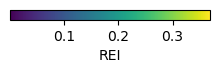

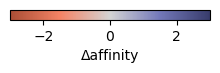

In [128]:
fig = plt.figure(figsize=(2, 1))
cax = fig.add_axes([0, 0, 1, 0.1])
plt.colorbar(cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin=vmin, vmax=vmax)),
             orientation='horizontal',
             cax=cax,
             label=f"{stat}")
plt.savefig(f"{output_dir}/cbar1.svg", bbox_inches="tight")
plt.show()

fig = plt.figure(figsize=(2, 1))
cax = fig.add_axes([0, 0, 1, 0.1])
plt.colorbar(cm.ScalarMappable(cmap=pc.affinity_trees_grey_centered.cmap, norm=pc.affinity_trees_grey_centered.norm),
             orientation='horizontal',
             cax=cax,
             label="Δaffinity")
plt.savefig(f"{output_dir}/cbar2.svg", bbox_inches="tight")
plt.show()

## Stack the tree svg's into a single image

define output directory and clear out any existing files

In [129]:
stacked_dir = f"{output_dir}/stacked_trees"
!mkdir -p {stacked_dir}
!rm {output_dir}/stacked_trees/PR*{scale}*.svg

zsh:1: no matches found: output/NDS-LB//naive_reversions_no_bp/stacked_trees/PR*20*.svg


In [130]:
# Set the maximum width for the display
pd.set_option('display.max_colwidth', None)

# Set the maximum number of columns to display
pd.set_option('display.max_columns', None)

Use svg utils to stitch together the trees rendered above.

In [131]:

for stat in ["REI", "binding"]:
    for duration in ["20", "15"]:

        files = sorted(glob.glob(f"{output_dir}/trees/D{duration}*{stat}.scale{scale}.svg"))
        files_df = pd.DataFrame(files, columns=["file"])
        files_df["UID"] = files_df.file.str.split(".").str[0].str.split("/").str[-1]
        files_df["mouse"] = files_df.file.str.extract(r"M(\d+)").astype(int)
        files_df["GC"] = files_df.file.str.extract(r"GC(\d+)").astype(int)
        files_df.sort_values(["mouse", "GC"], inplace=True)
        # print(stat, duration)
        # print(files_df.head())
        # print("======")
        # continue

        # Initial y position for stacking
        y_offset = 220
        all_panels = []
        all_panels.append(
           Text(f"IMM Duration: {duration} days", 200, 35, size=24, weight='bold')
        )

        # add colorbar
        cbar = "cbar1" if stat == "REI" else "cbar2"
        colorbar_svg = SVG(f"{output_dir}/{cbar}.svg").scale(2)
        colorbar_svg.move(175, 45)
        all_panels.append(colorbar_svg)

        # iterate through the tree, create a panel for each one.
        for i, (idx, row) in enumerate(files_df.iterrows()):

            position = (10, y_offset)
            #    annotation = f"Mouse: {row.mouse} GC: {row.GC}"
            annotation = row.UID
            panel = Panel(
                    SVG(row.file).scale(0.5),
                    Text(annotation, 10, -20, size=16, weight='bold')
            ).move(*position)
            all_panels.append(panel)
            if scale == 20:
                y_offset += 350
            else:
                y_offset += 125

        fig = Figure("%dpx"%1050, "%dpx" % y_offset ,*all_panels)
        print(f"saving to {output_dir}/D{duration}.{stat}.scale{scale}.svg")
        fig.save(f"{output_dir}/stacked_trees/D{duration}.{stat}.scale{scale}.svg")

saving to output/NDS-LB//naive_reversions_no_bp/D20.REI.scale20.svg
saving to output/NDS-LB//naive_reversions_no_bp/D15.REI.scale20.svg
saving to output/NDS-LB//naive_reversions_no_bp/D20.binding.scale20.svg
saving to output/NDS-LB//naive_reversions_no_bp/D15.binding.scale20.svg


# Affinity vs. REI

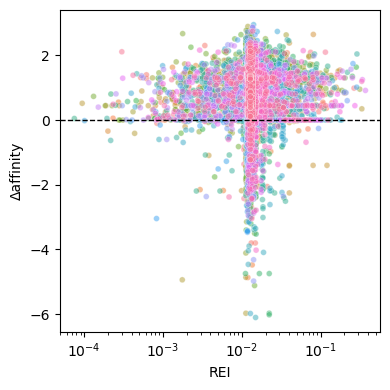

In [132]:
stat = "REI"
dat = []
for gc, tree in trees.items():
    for node in tree.tree.traverse():
        dat.append([gc, getattr(node, stat), node.delta_bind])

df_nodes = pd.DataFrame(dat, columns=["GC", stat, "Δaffinity"])

plt.figure(figsize=(4, 4))
sns.scatterplot(data=df_nodes, x=stat, y="Δaffinity", hue="GC", legend=False, alpha=0.5, size=.1)
plt.axhline(0, ls="--", c="k", lw=1)
plt.axvline(0, ls="--", c="k", lw=1)
plt.xscale("log")
plt.tight_layout()
plt.show()

## Summary

- Developed REI, because no branch lengths with LB
- Doesn't correlate will with GC affinity
- Recent motivated by evolving affinity

